# Explore latents for Brazil-Malvinis 
# This is a follow-up of Prof. X's work and several plot codes in this notebook come from Prof. X's Latents_Brazil Notebook

In [5]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [6]:
%matplotlib inline

In [7]:
# imports
from importlib import reload

import os
import numpy as np
import datetime

import pandas
import xarray
import h5py

import umap

from matplotlib import pyplot as plt
import seaborn as sns

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.models import io as model_io
from ulmo.modis import io as modis_io

In [8]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load em all

In [9]:
tbl_file = 's3://modis-l2/Tables/MODIS_L2_std.parquet'

In [10]:
modisl2_table = ulmo_io.load_main_table(tbl_file)

Read main table: s3://modis-l2/Tables/MODIS_L2_std.parquet


In [11]:
modisl2_table.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx
0,13.980967,62.675774,517,2003-03-10 21:25:00,520.178711,304,0.000000,26.199476,25.250000,26.885000,26.474998,25.814999,AQUA_MODIS.20030310T212506.L2.SST.nc,1047103981024267577,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,0
1,13.043748,-102.751816,706,2003-12-12 08:30:00,432.766724,1696,0.049805,28.924648,27.789999,29.654999,29.154999,28.695000,AQUA_MODIS.20031212T083006.L2.SST.nc,107110304377724818,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,1
2,-18.086618,40.844833,581,2003-09-24 22:35:00,764.413086,656,0.006104,25.551611,24.775000,26.154999,25.750000,25.344999,AQUA_MODIS.20030924T223506.L2.SST.nc,106471913422084483,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,2
3,39.071575,18.569141,1028,2003-05-01 01:05:00,371.310120,898,0.049988,16.414951,15.160000,17.205000,16.725000,16.080000,AQUA_MODIS.20030501T010506.L2.SST.nc,1051129071619856914,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,3
4,17.901926,90.155480,997,2003-12-05 19:55:00,-214.759277,1520,0.035461,26.744499,24.975000,28.724998,27.824999,25.830000,AQUA_MODIS.20031205T195506.L2.SST.nc,1070107901927015548,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,4


In [12]:
modisl2_table['DT'] = modisl2_table.T90 - modisl2_table.T10

## Load latents

In [13]:
latents_2019_file = 's3://modis-l2/Evaluations/MODIS_R2019_2019_95clear_128x128_latents_std.h5'

In [14]:
with ulmo_io.open(latents_2019_file, 'rb') as f:
    l_hf = h5py.File(f, 'r')

In [15]:
l_hf = h5py.File(ulmo_io.load_to_bytes(latents_2019_file), 'r')

In [16]:
latents_2019 = l_hf['latents'][:]

In [17]:
latents_2019.shape

(751689, 512)

# Isolate Brazil and $\Delta T \approx 2$K and 2019

## Location and $\Delta T$

In [18]:
# Brazil
in_brazil = ((np.abs(modisl2_table.lon.values + 57.5) < 10.)  & 
    (np.abs(modisl2_table.lat.values + 43.0) < 10))
in_DT = np.abs(modisl2_table.DT - 2.05) < 0.05

## Date

In [19]:
in_2019 = modisl2_table.datetime >= datetime.datetime(2019,1,1)

## Implement

In [20]:
evals_bz = modisl2_table[in_brazil & in_DT & in_2019].copy()

In [21]:
evals_bz.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx,DT
11607569,-46.332176,-56.542492,997,2019-01-26 05:10:00,-377.866211,272,0.007324,12.108228,10.135,14.775000,13.245,11.219999,AQUA_MODIS.20190126T051001.L2.SST.nc,154843667812345751,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...,standard,128,0,1209,2.025001
11608156,-44.843760,-58.942886,385,2019-01-30 04:45:00,-132.069763,353,0.049988,14.156826,11.660,15.724999,15.115,13.070000,AQUA_MODIS.20190130T044501.L2.SST.nc,154845156212105711,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...,standard,128,0,1796,2.045000
11608565,-41.851986,-57.806435,197,2019-09-13 04:30:00,80.636292,1033,0.049622,6.029055,3.855,7.935000,7.075,5.035000,AQUA_MODIS.20190913T043001.L2.SST.nc,156848148012219356,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...,standard,128,0,2205,2.040000
11608965,-47.914757,-59.783980,933,2019-04-07 05:15:00,-283.281372,1136,0.011292,8.955938,7.490,11.995000,10.050,8.035000,AQUA_MODIS.20190407T051500.L2.SST.nc,155442085212021602,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...,standard,128,0,2605,2.015000
11609712,-43.428630,-58.808018,357,2019-10-29 04:45:00,-40.530945,123,0.047852,7.469575,5.735,9.540000,8.665,6.585000,AQUA_MODIS.20191029T044501.L2.SST.nc,157246571412119198,s3://modis-l2/PreProc/MODIS_R2019_2019_95clear...,standard,128,0,3352,2.080000


# Cut on LL

In [22]:
lowLL = evals_bz.LL < -100
highLL = evals_bz.LL > 150
np.sum(lowLL), np.sum(highLL)

(198, 224)

In [23]:
all_cut = lowLL | highLL

## Grab the latents

In [24]:
cut_ppidx = evals_bz[all_cut].pp_idx
cut_ppidx

11607569      1209
11608156      1796
11608965      2605
11609747      3387
11610468      4108
             ...  
12346969    740609
12349970    743610
12351228    744868
12353860    747500
12355860    749500
Name: pp_idx, Length: 422, dtype: int64

In [25]:
cut_latents = latents_2019[cut_ppidx.values, :]

In [26]:
cut_latents.shape

(422, 512)

# Plot the histogram of LL

<AxesSubplot:xlabel='LL', ylabel='Count'>

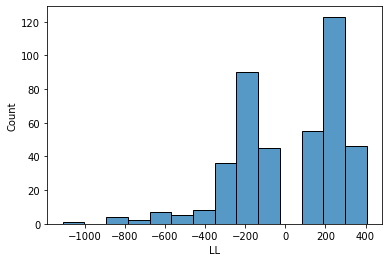

In [27]:
sns.histplot(evals_bz[all_cut].LL)

# UMAP straight up

In [28]:
reducer_umap = umap.UMAP()

In [29]:
latents_embedding = reducer_umap.fit_transform(cut_latents)

In [30]:
latents_embedding.shape

(422, 2)

## Plot me

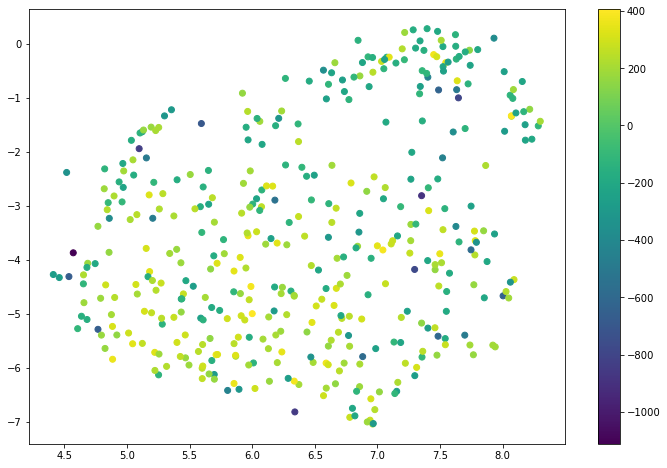

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(latents_embedding[:,0], latents_embedding[:,1], c=evals_bz[all_cut].LL)
plt.colorbar()
plt.show()

# If PCA is used before UMAP

In [32]:
pca = PCA(n_components=256, random_state=0)
latents_reduced = pca.fit_transform(cut_latents)
print(latents_reduced.shape)

(422, 256)


In [33]:
reducer_umap = umap.UMAP()

In [34]:
latents_red_embedding = reducer_umap.fit_transform(latents_reduced)

In [35]:
latents_red_embedding.shape

(422, 2)

## Plot me

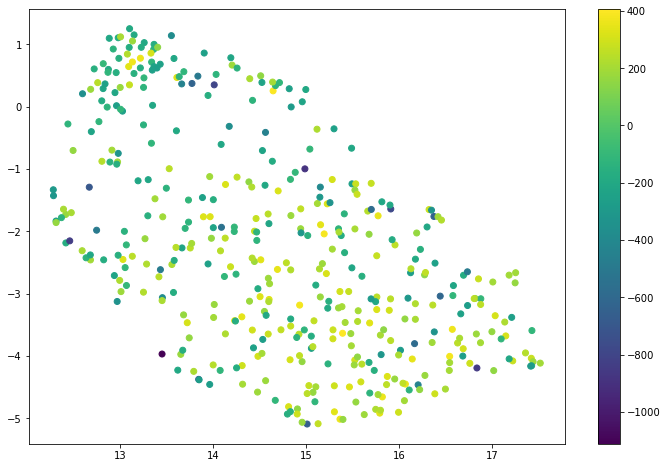

In [36]:
plt.figure(figsize=(12,8))
plt.scatter(latents_red_embedding[:,0], latents_red_embedding[:,1], c=evals_bz[all_cut].LL)
plt.colorbar()
plt.show()

# Give labels to the latents

In [37]:
lowLL = evals_bz.LL < -100
highLL = evals_bz.LL > 150

In [38]:
cut_ppidx_low = evals_bz[lowLL].pp_idx
cut_ppidx_high = evals_bz[highLL].pp_idx

In [70]:
index_low = evals_bz[lowLL].index
index_high = evals_bz[highLL].index
index_latents = np.concatenate((index_low, index_high), axis=0)

In [39]:
cut_latents_low = latents_2019[cut_ppidx_low.values, :]
cut_latents_high = latents_2019[cut_ppidx_high.values, :]

In [61]:
ll_low = evals_bz[lowLL].LL
ll_high = evals_bz[highLL].LL

In [62]:
ll_latents = np.concatenate((ll_low, ll_high), axis=0)

In [40]:
num_low = cut_latents_low.shape[0]
num_high = cut_latents_high.shape[0]
print(f'The number of latents with low ll is: {num_low}.')
print(f'The number of latents with low ll is: {num_high}.')

The number of latents with low ll is: 198.
The number of latents with low ll is: 224.


In [41]:
labels_low = np.ones(cut_latents_low.shape[0])
labels_high = np.zeros(cut_latents_high.shape[0])

In [42]:
cut_latents = np.concatenate((cut_latents_low, cut_latents_high), axis=0)

In [43]:
labels_latents = np.concatenate((labels_low, labels_high), axis=0)

In [44]:
reducer_umap = umap.UMAP()

In [45]:
latents_red_embedding = reducer_umap.fit_transform(latents_reduced)

In [46]:
latents_red_embedding.shape

(422, 2)

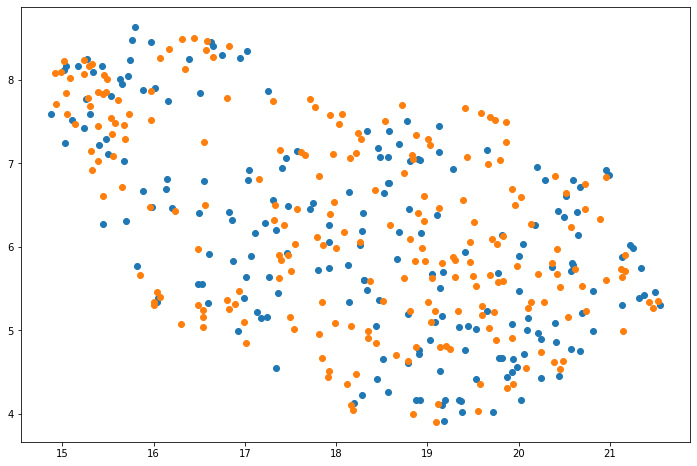

In [47]:
plt.figure(figsize=(12,8))
plt.scatter(latents_red_embedding[:num_low, 0], latents_red_embedding[:num_low, 1])
plt.scatter(latents_red_embedding[num_low:, 0], latents_red_embedding[num_low:, 1])
plt.show()

In [48]:
pca = PCA(n_components=256, random_state=0)
latents_reduced = pca.fit_transform(cut_latents)
print(latents_reduced.shape)

(422, 256)


In [49]:
reducer_umap = umap.UMAP()
latents_red_embedding = reducer_umap.fit_transform(latents_reduced)
latents_red_embedding.shape

(422, 2)

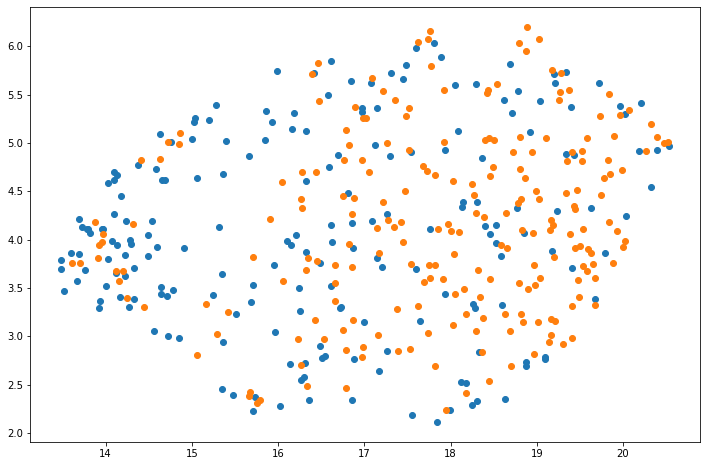

In [50]:
plt.figure(figsize=(12,8))
plt.scatter(latents_red_embedding[:num_low, 0], latents_red_embedding[:num_low, 1])
plt.scatter(latents_red_embedding[num_low:, 0], latents_red_embedding[num_low:, 1])
plt.show()

In [51]:
nca = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(n_components=2, random_state=0))

In [52]:
latents_embedded = nca.fit_transform(cut_latents, labels_latents)

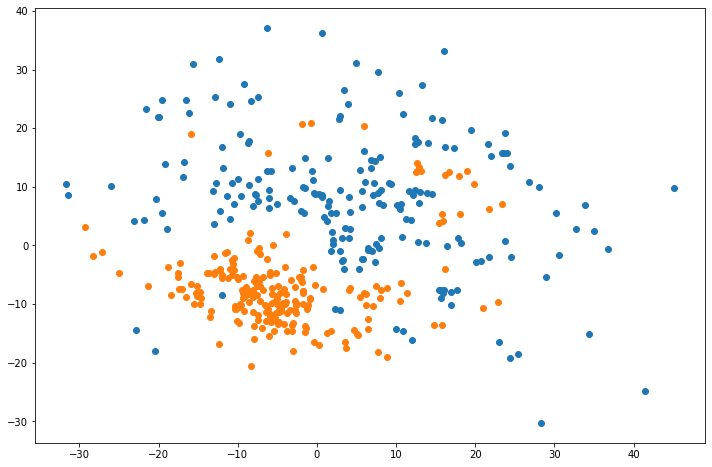

In [53]:
plt.figure(figsize=(12,8))
plt.scatter(latents_embedded[:num_low, 0], latents_embedded[:num_low, 1])
plt.scatter(latents_embedded[num_low:, 0], latents_embedded[num_low:, 1])
plt.show()

In [54]:
knn = KNeighborsClassifier(n_neighbors=5)

In [55]:
knn.fit(latents_embedded, labels_latents)

KNeighborsClassifier()

In [56]:
from matplotlib.colors import ListedColormap

In [57]:
h = 1
x_min, x_max = latents_embedded[:, 0].min() - 1, latents_embedded[:, 0].max() + 1
y_min, y_max = latents_embedded[:, 1].min() - 1, latents_embedded[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Text(0, 0.5, 'second dimension of the reduced latents')

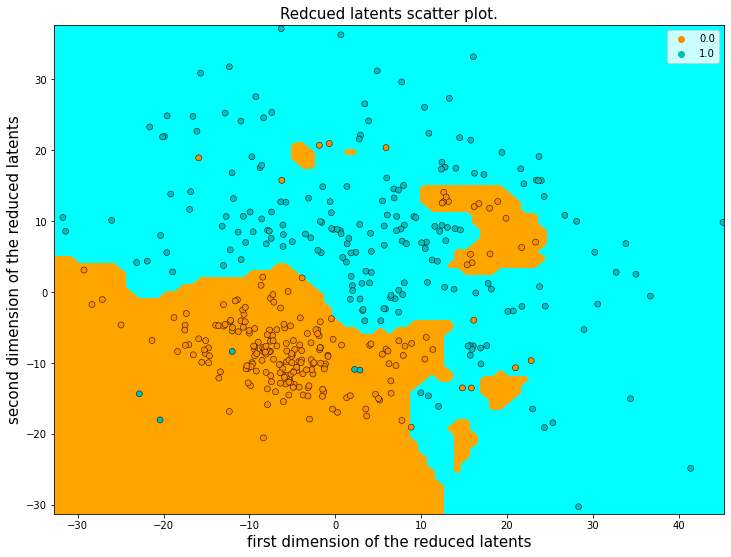

In [59]:
cmap_light = ListedColormap(['orange', 'cyan'])
cmap_bold = ['darkorange', 'c']
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12, 9))
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x=latents_embedded[:, 0], y=latents_embedded[:, 1], hue=labels_latents,
                palette=cmap_bold, alpha=1, edgecolor="black")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Redcued latents scatter plot.', fontsize=15)
plt.xlabel('first dimension of the reduced latents', fontsize=15)
plt.ylabel('second dimension of the reduced latents', fontsize=15)

# Show the similar cutouts 

In [72]:
indice_ll_least = np.argmin(ll_latents)

In [73]:
latent_least = latents_embedded[indice_ll_least, :]

In [74]:
indice_ll_least = index_latents[indice_ll_least]

In [79]:
cutout_M = modisl2_table.iloc[indice_ll_least]
img_modis = modis_io.grab_image(cutout_M)

In [80]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

<AxesSubplot:>

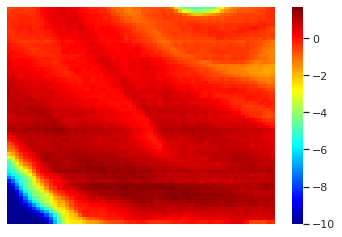

In [81]:
sns.heatmap(img_modis, xticklabels=[], yticklabels=[], cmap=cm, 
            cbar=True)

In [82]:
import sklearn.neighbors as neighbors

In [83]:
n_neighbors = 5
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(latents_embedded, labels_latents)

KNeighborsClassifier(weights='distance')

In [84]:
latent_least = np.expand_dims(latent_least, axis=0)
distance_list, neighbor_list = clf.kneighbors(latent_least, n_neighbors=10)

In [85]:
neighbor_list

array([[ 62,  42,  51, 118, 123, 154,  81, 397,  37, 313]])

In [86]:
img_modis_list = []
for index in neighbor_list[0]:
    index_ll = index_latents[index]
    cutout_M = modisl2_table.iloc[index_ll]
    img_modis_list.append(modis_io.grab_image(cutout_M))

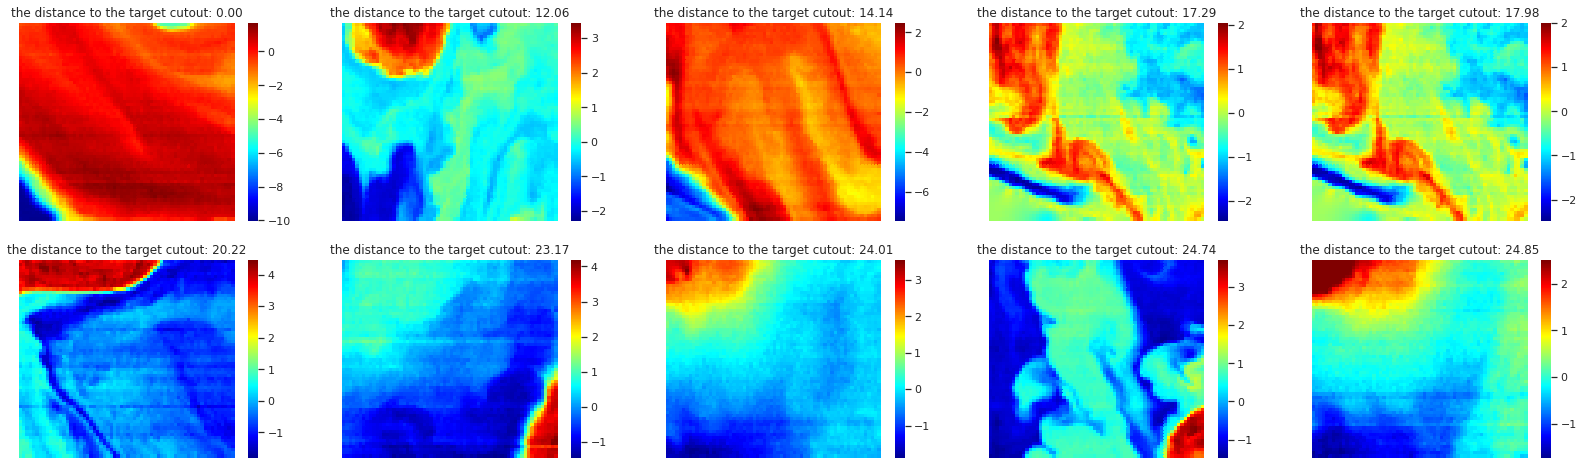

In [87]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(img_modis_list[i], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {distance_list[0][i]:.2f}')

# Show the cutouts in the scatter plot of latents

In [98]:
latents_list = [latents_embedded[i, :] for i in neighbor_list[0]]

In [99]:
x_latents_list = [latents_list[i][0] for i in range(10)]
y_latents_list = [latents_list[i][1] for i in range(10)]

In [100]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [133]:
len_square = 1.2 * (x_max - x_min)
height_square = 0.95 * (y_max - y_min)
x_square = x_min * 0.95
y_square = y_min * 0.95

In [123]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.patches import Rectangle
from matplotlib.cbook import get_sample_data

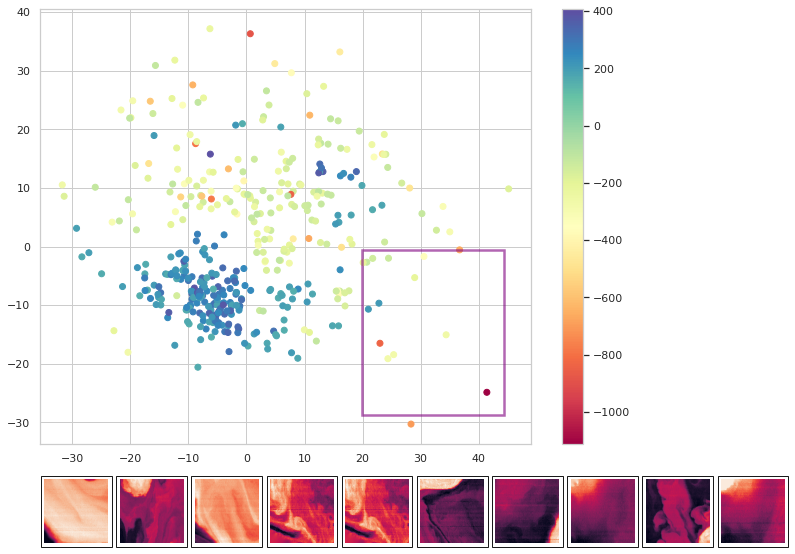

In [148]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
#ax.scatter(reduced_latents[3:left_size, 0], reduced_latents[3:left_size, 1], c=ll_sampled[3:left_size], 
#           cmap='Spectral')
plt.scatter(latents_embedded[:, 0], latents_embedded[:, 1], c=ll_latents, cmap='Spectral')
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='purple',
                        lw = 2.5, 
                        alpha=0.6) )
plt.colorbar()
#####################################################################
### plot the cutouts
width, step = 73, 34.5 / 16
x_box, y_box = -170., -265.
xy = (0, 0)
ab_list = []
for i in range(5):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, y_box)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)
#y_box = y_box - width
for i in range(5, 10):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, y_box)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)

# Show the similar cutouts with high LL

In [172]:
indice_ll_max = np.argmax(ll_latents)

In [173]:
latent_max = latents_embedded[indice_ll_max, :]

In [174]:
indice_ll_max = index_latents[indice_ll_max]

In [175]:
cutout_M = modisl2_table.iloc[indice_ll_max]
img_modis = modis_io.grab_image(cutout_M)

In [176]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

<AxesSubplot:>

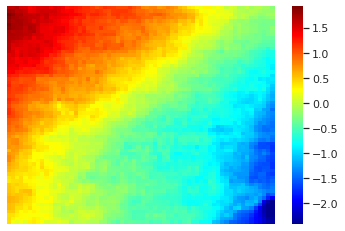

In [177]:
sns.heatmap(img_modis, xticklabels=[], yticklabels=[], cmap=cm, 
            cbar=True)

In [178]:
latent_max = np.expand_dims(latent_max, axis=0)
distance_list, neighbor_list = clf.kneighbors(latent_max, n_neighbors=10)

In [179]:
neighbor_list

array([[226, 396, 268, 352, 316, 324, 315, 330, 249, 365]])

In [180]:
img_modis_list = []
for index in neighbor_list[0]:
    index_ll = index_latents[index]
    cutout_M = modisl2_table.iloc[index_ll]
    img_modis_list.append(modis_io.grab_image(cutout_M))

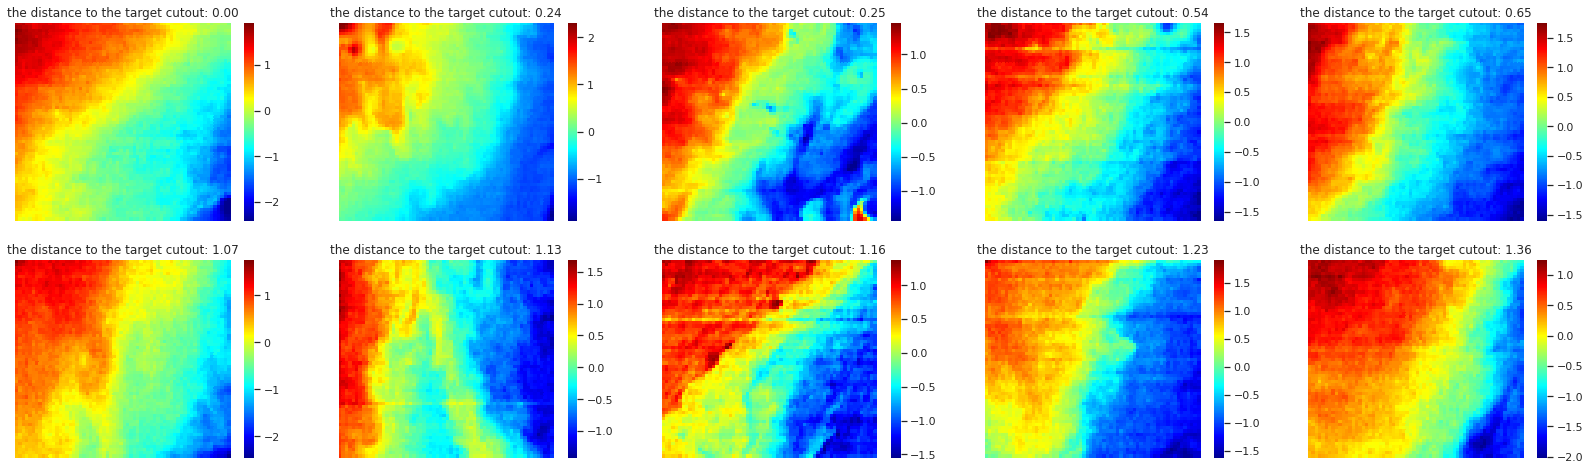

In [181]:
plt.figure(figsize=(28, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.heatmap(img_modis_list[i], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {distance_list[0][i]:.2f}')

# Show the cutouts in the scatter plot of latents with high LL

In [182]:
latents_list = [latents_embedded[i, :] for i in neighbor_list[0]]

In [183]:
x_latents_list = [latents_list[i][0] for i in range(10)]
y_latents_list = [latents_list[i][1] for i in range(10)]

In [184]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [185]:
len_square = 1.0 * (x_max - x_min)
height_square = 1.0 * (y_max - y_min)
x_square = x_min
y_square = y_min 

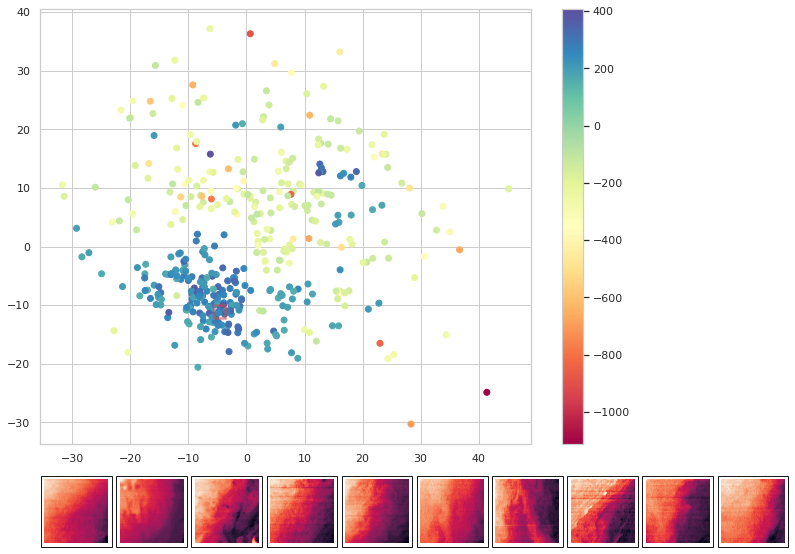

In [187]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
#ax.scatter(reduced_latents[3:left_size, 0], reduced_latents[3:left_size, 1], c=ll_sampled[3:left_size], 
#           cmap='Spectral')
plt.scatter(latents_embedded[:, 0], latents_embedded[:, 1], c=ll_latents, cmap='Spectral')
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='r',
                        lw = 2.5, 
                        alpha=0.6) )
plt.colorbar()
#####################################################################
### plot the cutouts
width, step = 73, 34.5 / 16
x_box, y_box = -170., -265.
xy = (0, 0)
ab_list = []
for i in range(5):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, y_box)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)
#y_box = y_box - width
for i in range(5, 10):
    x_box_i = x_box + i * (width + step)
    xybox = (x_box_i, y_box)
    imagebox = OffsetImage(img_modis_list[i], zoom=1)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, 
                        xybox, 
                        xycoords='data', 
                        boxcoords='offset points', 
                        pad=0.3)
    ax.add_artist(ab)

# Similarity 

In [153]:
norm_latent = np.linalg.norm(np.array(latents_embedded).astype(float), axis=1)

In [154]:
norm_latents = latents_embedded / np.outer(norm_latent, np.ones(2))

# Prediction by KNN

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
latents_train, latents_test, labels_train, labels_test = train_test_split(latents_embedded, labels_latents, 
                                                                          test_size=0.2, random_state=0)

In [97]:
knn.fit(latents_train, labels_train)
knn.score(latents_test, labels_test)

0.9294117647058824

## Predcition accuracy is about $0.93$.

-------------------------------------------------------------------------------------------

## Neighborhoods of the target Cutout

In [166]:
np.random.seed(0)

In [167]:
random_sample_low = np.random.choice(range(num_low), 1).squeeze()

In [216]:
cutout_low = modisl2_table.iloc[cut_ppidx_low.index.values[random_sample_low]]

In [217]:
cutout_img = modis_io.grab_image(cutout_low)

In [218]:
pal, cm = plotting.load_palette()

<AxesSubplot:>

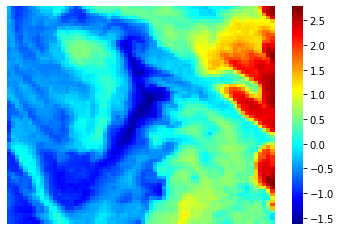

In [219]:
sns.heatmap(cutout_img, xticklabels=[], yticklabels=[], cmap=cm, 
            cbar=True)

In [182]:
latents_sampled_low = np.expand_dims(latents_embedded[random_sample_low], axis=0)

In [157]:
knn = KNeighborsClassifier(n_neighbors=5)

In [158]:
knn.fit(latents_embedded, labels_latents)

KNeighborsClassifier()

In [186]:
distance_list, neighbor_list = knn.kneighbors(latents_sampled_low)

In [193]:
cutout_low_list = [modisl2_table.iloc[cut_ppidx_low.index.values[index]] for index in neighbor_list[0]]

In [196]:
modis_img_list = [modis_io.grab_image(cutout_low) for cutout_low in cutout_low_list]

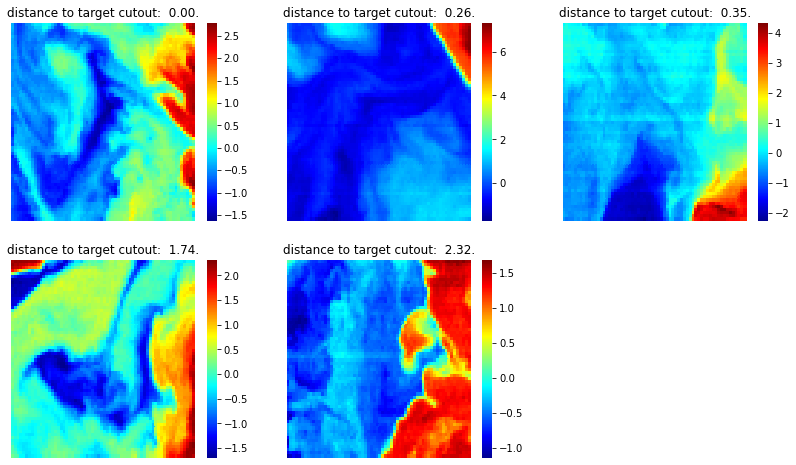

In [223]:
plt.figure(figsize=(14, 8))
for i, cutout_img in enumerate(modis_img_list):
    plt.subplot(2, 3, i+1)
    sns.heatmap(cutout_img, xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'distance to target cutout: {distance_list[0][i]: .2f}.')

# Plot the vectors

In [37]:
low_idx = np.where(evals_bz[all_cut].LL < -100)[0]
high_idx = np.where(evals_bz[all_cut].LL > 150)[0]

In [38]:
median_low_latent = np.median(cut_latents[low_idx,:], axis=0)
median_low_latent.shape

(512,)

In [39]:
median_high_latent = np.median(cut_latents[high_idx,:], axis=0)

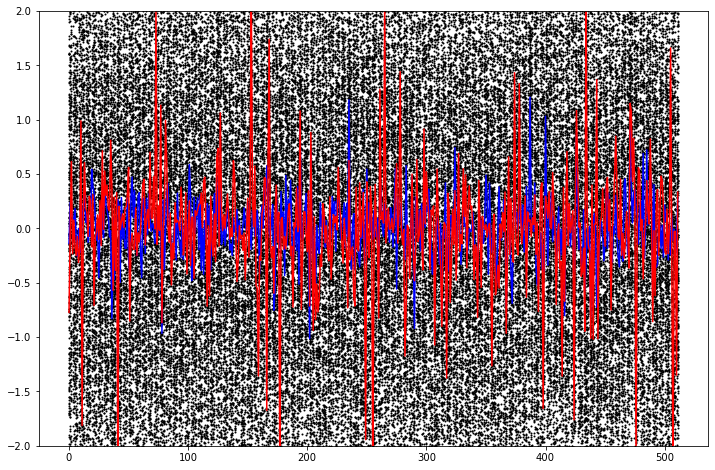

In [40]:
plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(median_low_latent, color='b')
ax.plot(median_high_latent, color='r')
# Scatter the rest
for idx in low_idx:
    ax.scatter(np.arange(median_low_latent.size), cut_latents[idx, :], s=1, color='k')
#
ax.set_ylim(-2, 2.)
#ax.set_xlim(0,100)
#
plt.show()

# Dot product

## Normalize

In [43]:
norm_latent = np.linalg.norm(cut_latents[:].astype(float), axis=1)

In [44]:
norm_latents = cut_latents / np.outer(norm_latent, np.ones(512))

In [45]:
low_latents = norm_latents[low_idx, :]
high_latents = norm_latents[high_idx, :]

## Low with itself

In [46]:
low_dots = np.dot(low_latents, low_latents[0, :])

<AxesSubplot:ylabel='Count'>

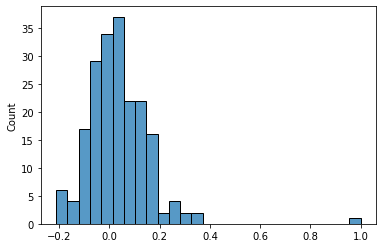

In [47]:
sns.histplot(low_dots)

## Low with High

In [48]:
lowhigh_dots = np.dot(high_latents, low_latents[0, :])

<AxesSubplot:ylabel='Count'>

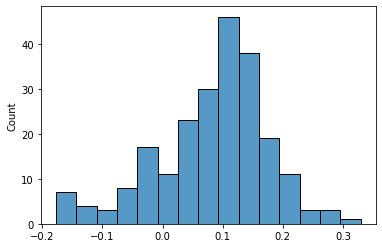

In [49]:
sns.histplot(lowhigh_dots)